In [1]:
!pip -q install albumentations opencv-python tqdm

import os, random, math, gc
import numpy as np
from dataclasses import dataclass
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split

import torchvision
from torchvision.datasets import OxfordIIITPet

import albumentations as A
import cv2
import matplotlib.pyplot as plt

# Utilities
def seed_everything(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

def cleanup_cuda():
    gc.collect()
    torch.cuda.empty_cache()

seed_everything(42)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

@dataclass
class CFG:
    img_size: int = 256
    num_classes: int = 3
    base_width: int = 32
    dropout_p: float = 0.20

    batch_size_train: int = 16
    batch_size_eval: int = 8
    batch_size_cal: int = 4
    num_workers: int = 2

    lr: float = 2e-4
    weight_decay: float = 1e-4
    epochs: int = 10
    amp: bool = True

    mc_samples: int = 20

cfg = CFG()


Device: cuda


In [2]:

# Dataset
class OxfordPetsSeg(Dataset):
    """
    OxfordIIITPet target mask values are {1,2,3}; map to {0,1,2}.
    """
    def __init__(self, root, split="trainval", img_size=256, augment=False):
        self.ds = OxfordIIITPet(root=root, split=split, target_types="segmentation", download=True)
        self.img_size = img_size

        if augment:
            self.tf = A.Compose([
                A.Resize(img_size, img_size),
                A.HorizontalFlip(p=0.5),
                A.RandomBrightnessContrast(p=0.25),
                A.HueSaturationValue(p=0.25),
                A.ShiftScaleRotate(shift_limit=0.03, scale_limit=0.08, rotate_limit=10, p=0.25),
            ])
        else:
            self.tf = A.Compose([A.Resize(img_size, img_size)])

        self.norm = A.Normalize(mean=(0.485,0.456,0.406), std=(0.229,0.224,0.225))

    def __len__(self):
        return len(self.ds)

    def __getitem__(self, idx):
        img_pil, mask_pil = self.ds[idx]
        img = np.array(img_pil)
        mask = np.array(mask_pil).astype(np.int64) - 1

        out = self.tf(image=img, mask=mask)
        img, mask = out["image"], out["mask"]

        img = self.norm(image=img)["image"]
        img = torch.from_numpy(img.transpose(2,0,1)).float()
        mask = torch.from_numpy(mask).long()
        return img, mask

root = "./data_oxfordpets"
full_aug = OxfordPetsSeg(root=root, split="trainval", img_size=cfg.img_size, augment=True)

val_frac = 0.15
n_val = int(len(full_aug)*val_frac)
n_train = len(full_aug) - n_val
train_ds, val_idx_ds = random_split(full_aug, [n_train, n_val], generator=torch.Generator().manual_seed(42))

val_base = OxfordPetsSeg(root=root, split="trainval", img_size=cfg.img_size, augment=False)
val_ds = torch.utils.data.Subset(val_base, val_idx_ds.indices)
test_ds = OxfordPetsSeg(root=root, split="test", img_size=cfg.img_size, augment=False)

train_loader = DataLoader(train_ds, batch_size=cfg.batch_size_train, shuffle=True,
                          num_workers=cfg.num_workers, pin_memory=True)
val_loader_eval = DataLoader(val_ds, batch_size=cfg.batch_size_eval, shuffle=False,
                             num_workers=cfg.num_workers, pin_memory=True)
val_loader_cal = DataLoader(val_ds, batch_size=cfg.batch_size_cal, shuffle=False,
                            num_workers=cfg.num_workers, pin_memory=True)
test_loader = DataLoader(test_ds, batch_size=cfg.batch_size_eval, shuffle=False,
                         num_workers=cfg.num_workers, pin_memory=True)

print("Train/Val/Test:", len(train_ds), len(val_ds), len(test_ds))


100%|██████████| 792M/792M [00:44<00:00, 17.8MB/s]
100%|██████████| 19.2M/19.2M [00:02<00:00, 9.19MB/s]


Train/Val/Test: 3128 552 3669


/usr/local/lib/python3.12/dist-packages/albumentations/core/validation.py:114: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)


In [3]:
# Model: U-Net with Dropout2D

class ConvBlock(nn.Module):
    def __init__(self, in_ch, out_ch, p_drop=0.0):
        super().__init__()
        self.conv1 = nn.Conv2d(in_ch, out_ch, 3, padding=1, bias=False)
        self.bn1   = nn.BatchNorm2d(out_ch)
        self.conv2 = nn.Conv2d(out_ch, out_ch, 3, padding=1, bias=False)
        self.bn2   = nn.BatchNorm2d(out_ch)
        self.drop  = nn.Dropout2d(p_drop)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.drop(x)
        x = F.relu(self.bn2(self.conv2(x)))
        return x

class UNet(nn.Module):
    def __init__(self, in_ch=3, num_classes=3, base=32, p_drop=0.2):
        super().__init__()
        self.enc1 = ConvBlock(in_ch, base, p_drop); self.pool1 = nn.MaxPool2d(2)
        self.enc2 = ConvBlock(base, base*2, p_drop); self.pool2 = nn.MaxPool2d(2)
        self.enc3 = ConvBlock(base*2, base*4, p_drop); self.pool3 = nn.MaxPool2d(2)
        self.enc4 = ConvBlock(base*4, base*8, p_drop); self.pool4 = nn.MaxPool2d(2)

        self.bott = ConvBlock(base*8, base*16, p_drop)

        self.up4 = nn.ConvTranspose2d(base*16, base*8, 2, stride=2); self.dec4 = ConvBlock(base*16, base*8, p_drop)
        self.up3 = nn.ConvTranspose2d(base*8, base*4, 2, stride=2);  self.dec3 = ConvBlock(base*8, base*4, p_drop)
        self.up2 = nn.ConvTranspose2d(base*4, base*2, 2, stride=2);  self.dec2 = ConvBlock(base*4, base*2, p_drop)
        self.up1 = nn.ConvTranspose2d(base*2, base, 2, stride=2);    self.dec1 = ConvBlock(base*2, base, p_drop)

        self.head = nn.Conv2d(base, num_classes, 1)

    def forward(self, x):
        e1 = self.enc1(x)
        e2 = self.enc2(self.pool1(e1))
        e3 = self.enc3(self.pool2(e2))
        e4 = self.enc4(self.pool3(e3))
        b  = self.bott(self.pool4(e4))

        d4 = self.dec4(torch.cat([self.up4(b), e4], dim=1))
        d3 = self.dec3(torch.cat([self.up3(d4), e3], dim=1))
        d2 = self.dec2(torch.cat([self.up2(d3), e2], dim=1))
        d1 = self.dec1(torch.cat([self.up1(d2), e1], dim=1))
        return self.head(d1)

model = UNet(num_classes=cfg.num_classes, base=cfg.base_width, p_drop=cfg.dropout_p).to(device)
print("Params (M):", sum(p.numel() for p in model.parameters())/1e6)

Params (M): 7.763107


In [4]:
# Loss + metrics

def dice_loss_from_logits(logits, targets, num_classes, eps=1e-6):
    probs = torch.softmax(logits, dim=1)
    onehot = F.one_hot(targets, num_classes).permute(0,3,1,2).float()
    dims = (0,2,3)
    inter = torch.sum(probs * onehot, dims)
    union = torch.sum(probs + onehot, dims)
    dice = (2*inter + eps) / (union + eps)
    return 1 - dice.mean()

def mean_iou(pred, target, num_classes, ignore_index=None):
    ious = []
    for cls in range(num_classes):
        if ignore_index is not None:
            valid = target != ignore_index
            p, t = pred[valid], target[valid]
        else:
            p, t = pred, target
        pred_c = (p == cls)
        targ_c = (t == cls)
        inter = (pred_c & targ_c).sum().item()
        union = (pred_c | targ_c).sum().item()
        if union == 0:
            continue
        ious.append(inter / union)
    return float(np.mean(ious)) if len(ious) else 0.0

In [5]:
# Train

opt = torch.optim.AdamW(model.parameters(), lr=cfg.lr, weight_decay=cfg.weight_decay)
scaler = torch.cuda.amp.GradScaler(enabled=cfg.amp)

def run_epoch(loader, train=True):
    model.train(train)
    total_loss, total_iou, n = 0.0, 0.0, 0
    for x, y in tqdm(loader, leave=False):
        x = x.to(device, non_blocking=True)
        y = y.to(device, non_blocking=True)

        with torch.cuda.amp.autocast(enabled=cfg.amp):
            logits = model(x)
            ce = F.cross_entropy(logits, y)
            dl = dice_loss_from_logits(logits, y, cfg.num_classes)
            loss = 0.7*ce + 0.3*dl

        if train:
            opt.zero_grad(set_to_none=True)
            scaler.scale(loss).backward()
            scaler.step(opt)
            scaler.update()

        with torch.no_grad():
            pred = logits.argmax(dim=1)
            iou = mean_iou(pred, y, cfg.num_classes)

        total_loss += loss.item() * x.size(0)
        total_iou  += iou * x.size(0)
        n += x.size(0)

        del x, y, logits, pred, loss, ce, dl
    return total_loss/max(1,n), total_iou/max(1,n)

best_val = -1
for epoch in range(cfg.epochs):
    tr_loss, tr_iou = run_epoch(train_loader, train=True)
    cleanup_cuda()
    va_loss, va_iou = run_epoch(val_loader_eval, train=False)
    cleanup_cuda()
    print(f"Epoch {epoch+1:02d}/{cfg.epochs} | train loss {tr_loss:.4f} iou {tr_iou:.4f} | val loss {va_loss:.4f} iou {va_iou:.4f}")
    if va_iou > best_val:
        best_val = va_iou
        torch.save(model.state_dict(), "best_unet.pth")
        print("  Saved best checkpoint.")

model.load_state_dict(torch.load("best_unet.pth", map_location=device))
print("Best val mIoU:", best_val)
cleanup_cuda()

/tmp/ipython-input-2337492572.py:4: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=cfg.amp)
  0%|          | 0/196 [00:00<?, ?it/s]/tmp/ipython-input-2337492572.py:13: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=cfg.amp):


Epoch 01/10 | train loss 0.7744 iou 0.3535 | val loss 0.6125 iou 0.4339
  Saved best checkpoint.


Epoch 02/10 | train loss 0.6416 iou 0.4407 | val loss 0.5469 iou 0.5052
  Saved best checkpoint.


Epoch 03/10 | train loss 0.5616 iou 0.5090 | val loss 0.4653 iou 0.5703
  Saved best checkpoint.


Epoch 04/10 | train loss 0.5020 iou 0.5530 | val loss 0.4296 iou 0.5945
  Saved best checkpoint.


Epoch 05/10 | train loss 0.4653 iou 0.5757 | val loss 0.3944 iou 0.6186
  Saved best checkpoint.


Epoch 06/10 | train loss 0.4424 iou 0.5929 | val loss 0.3803 iou 0.6325
  Saved best checkpoint.


Epoch 07/10 | train loss 0.4288 iou 0.6021 | val loss 0.3612 iou 0.6409
  Saved best checkpoint.


Epoch 08/10 | train loss 0.4062 iou 0.6192 | val loss 0.3458 iou 0.6649
  Saved best checkpoint.


Epoch 09/10 | train loss 0.3928 iou 0.6284 | val loss 0.3398 iou 0.6621


Epoch 10/10 | train loss 0.3843 iou 0.6354 | val loss 0.3255 iou 0.6722
  Saved best checkpoint.
Best val mIoU: 0.6721563690850388


In [6]:
# Temperature Scaling (memory-safe Adam, no full-val graph)

class TemperatureScaler(nn.Module):
    def __init__(self, init_temp=1.0):
        super().__init__()
        self.log_temp = nn.Parameter(torch.tensor([math.log(init_temp)], dtype=torch.float32))
    def temperature(self):
        return torch.exp(self.log_temp).clamp(0.05, 20.0)
    def forward(self, logits):
        return logits / self.temperature()

@torch.no_grad()
def nll_on_loader(model, loader, temp=1.0, use_amp=True):
    model.eval()
    T = float(temp)
    total, n = 0.0, 0
    for x, y in tqdm(loader, desc="NLL", leave=False):
        x = x.to(device, non_blocking=True)
        y = y.to(device, non_blocking=True)
        with torch.cuda.amp.autocast(enabled=use_amp):
            logits = model(x) / T
            loss = F.cross_entropy(logits, y, reduction="mean")
        total += loss.item() * x.size(0)
        n += x.size(0)
        del x, y, logits, loss
    return total/max(1,n)

def fit_temperature_adam(model, val_loader, steps=150, lr=0.05):
    model.eval()
    for p in model.parameters():
        p.requires_grad_(False)

    ts = TemperatureScaler(1.0).to(device)
    opt_ts = torch.optim.Adam(ts.parameters(), lr=lr)

    it = 0
    pbar = tqdm(total=steps, desc="Fit temperature (Adam)")
    while it < steps:
        for x, y in val_loader:
            if it >= steps:
                break
            x = x.to(device, non_blocking=True)
            y = y.to(device, non_blocking=True)

            opt_ts.zero_grad(set_to_none=True)

            # gradients only through temperature
            logits = model(x).detach()
            scaled = ts(logits)
            loss = F.cross_entropy(scaled, y, reduction="mean")
            loss.backward()
            opt_ts.step()

            it += 1
            pbar.update(1)

            del x, y, logits, scaled, loss
            # keep cache light
            if it % 20 == 0:
                cleanup_cuda()

    pbar.close()
    return ts.temperature().item()

print("Fitting temperature on validation set...")
cleanup_cuda()
nll_before = nll_on_loader(model, val_loader_cal, temp=1.0, use_amp=True)
T_star = fit_temperature_adam(model, val_loader_cal, steps=150, lr=0.05)
cleanup_cuda()
nll_after = nll_on_loader(model, val_loader_cal, temp=T_star, use_amp=True)
print(f"T*: {T_star:.4f}")
print(f"Val NLL before: {nll_before:.4f} | after: {nll_after:.4f}")

Fitting temperature on validation set...


NLL:   0%|          | 0/138 [00:00<?, ?it/s]/tmp/ipython-input-1676813401.py:20: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=use_amp):
Fit temperature (Adam): 100%|██████████| 150/150 [00:03<00:00, 40.21it/s]
                                                      

T*: 1.0090
Val NLL before: 0.3449 | after: 0.3448


In [7]:
# Pixel-wise ECE (deterministic) before/after temperature scaling

@torch.no_grad()
def pixel_ece_deterministic(model, loader, temp=1.0, n_bins=15):
    model.eval()
    T = float(temp)
    bins = torch.linspace(0, 1, n_bins+1, device=device)

    bin_acc = torch.zeros(n_bins, device=device)
    bin_conf = torch.zeros(n_bins, device=device)
    bin_count = torch.zeros(n_bins, device=device)

    for x, y in tqdm(loader, desc="ECE", leave=False):
        x = x.to(device, non_blocking=True)
        y = y.to(device, non_blocking=True)

        logits = model(x) / T
        probs = torch.softmax(logits, dim=1)
        conf, pred = probs.max(dim=1)     # B,H,W
        correct = (pred == y).float()

        confv = conf.reshape(-1)
        corrv = correct.reshape(-1)

        for b in range(n_bins):
            lo, hi = bins[b], bins[b+1]
            mask = (confv > lo) & (confv <= hi)
            if mask.any():
                cnt = mask.sum()
                bin_count[b] += cnt
                bin_acc[b] += corrv[mask].sum()
                bin_conf[b] += confv[mask].sum()

        del x, y, logits, probs, conf, pred, correct, confv, corrv

    total = bin_count.sum().clamp_min(1)
    ece = torch.zeros((), device=device)
    for b in range(n_bins):
        if bin_count[b] > 0:
            acc = bin_acc[b] / bin_count[b]
            cfm = bin_conf[b] / bin_count[b]
            ece += (bin_count[b] / total) * torch.abs(acc - cfm)

    return float(ece.item())

ece_before = pixel_ece_deterministic(model, test_loader, temp=1.0, n_bins=15)
cleanup_cuda()
ece_after  = pixel_ece_deterministic(model, test_loader, temp=T_star, n_bins=15)
cleanup_cuda()
print(f"Test Pixel ECE before: {ece_before:.4f} | after temp scaling: {ece_after:.4f}")

Test Pixel ECE before: 0.0131 | after temp scaling: 0.0118


In [8]:
# MC Dropout inference (STREAMING - no stacking big tensors)

def enable_dropout_only(m):
    if isinstance(m, (nn.Dropout, nn.Dropout2d, nn.AlphaDropout)):
        m.train()

@torch.no_grad()
def mc_predict_streaming(model, x, T_mc=20, temp=1.0):
    model.eval()
    model.apply(enable_dropout_only)
    Tscale = float(temp)

    sum_probs = None
    sum_ent = None

    for _ in range(T_mc):
        logits = model(x) / Tscale
        probs = torch.softmax(logits, dim=1)  # B,C,H,W
        ent = -torch.sum(probs * torch.log(probs.clamp_min(1e-8)), dim=1)  # B,H,W

        if sum_probs is None:
            sum_probs = probs
            sum_ent = ent
        else:
            sum_probs = sum_probs + probs
            sum_ent = sum_ent + ent

        del logits, probs, ent

    mean_probs = sum_probs / T_mc
    mean_ent_per_pass = sum_ent / T_mc

    pred = mean_probs.argmax(dim=1)
    conf = mean_probs.max(dim=1).values
    pred_entropy = -torch.sum(mean_probs * torch.log(mean_probs.clamp_min(1e-8)), dim=1)
    mutual_info = pred_entropy - mean_ent_per_pass

    return mean_probs, pred, pred_entropy, mutual_info, conf

In [8]:
# Fixed-coverage thresholds + Selective Risk / Selective mIoU

@torch.no_grad()
def estimate_uncertainty_thresholds(loader, coverages, T_mc=20, temp=1.0, score="entropy",
                                    pixels_per_batch_sample=8192):
    """
    Estimate thresholds tau_alpha such that roughly alpha fraction of pixels are accepted (u <= tau_alpha).
    Uses sampled uncertainties to keep memory small.
    """
    u_samples = []
    for x, y in tqdm(loader, desc="Sampling uncertainties (thresholds)", leave=False):
        x = x.to(device, non_blocking=True)
        _, _, pe, mi, _ = mc_predict_streaming(model, x, T_mc=T_mc, temp=temp)
        u = pe if score == "entropy" else mi
        u_flat = u.reshape(-1)

        if u_flat.numel() > pixels_per_batch_sample:
            idx = torch.randint(0, u_flat.numel(), (pixels_per_batch_sample,), device=u_flat.device)
            u_flat = u_flat[idx]

        u_samples.append(u_flat.detach().cpu())
        del x, y, pe, mi, u, u_flat
    u_samples = torch.cat(u_samples).numpy()
    u_samples.sort()

    thresholds = {}
    for cov in coverages:
        cov = float(np.clip(cov, 0.0, 1.0))
        thresholds[cov] = float(np.quantile(u_samples, cov))
    return thresholds

@torch.no_grad()
def selective_metrics_fixed_coverage(loader, thresholds_by_cov, T_mc=20, temp=1.0, score="entropy"):
    """
    Compute at each coverage:
      - realized coverage
      - selective risk (pixel error rate on accepted pixels)
      - selective mIoU (ignore rejected pixels)
    """
    ignore_index = 255
    results = []

    for cov, thr in sorted(thresholds_by_cov.items(), key=lambda x: x[0], reverse=True):
        total_valid = 0
        total_pixels = 0
        total_err = 0
        miou_sum = 0.0
        n_img = 0

        for x, y in tqdm(loader, desc=f"Eval @target cov={cov:.2f}", leave=False):
            x = x.to(device, non_blocking=True)
            y = y.to(device, non_blocking=True)

            _, pred, pe, mi, _ = mc_predict_streaming(model, x, T_mc=T_mc, temp=temp)
            u = pe if score == "entropy" else mi
            valid = (u <= thr)

            total_valid += valid.sum().item()
            total_pixels += valid.numel()
            total_err += ((pred != y) & valid).sum().item()

            y_sel = y.clone()
            y_sel[~valid] = ignore_index
            miou_sum += mean_iou(pred, y_sel, cfg.num_classes, ignore_index=ignore_index)
            n_img += 1

            del x, y, pred, pe, mi, u, valid, y_sel

        realized_cov = total_valid / max(1, total_pixels)
        risk = total_err / max(1, total_valid)
        sel_miou = miou_sum / max(1, n_img)

        results.append({
            "target_coverage": cov,
            "threshold": thr,
            "realized_coverage": realized_cov,
            "selective_risk": risk,
            "selective_miou": sel_miou
        })

    return results

coverages = [1.00, 0.95, 0.90, 0.85, 0.80, 0.75, 0.70, 0.65, 0.60]

# Protocol option:
# - estimate thresholds on VAL and evaluate on TEST (recommended)
thresholds_val = estimate_uncertainty_thresholds(
    val_loader_eval, coverages=coverages, T_mc=cfg.mc_samples, temp=T_star, score="entropy"
)
cleanup_cuda()

results = selective_metrics_fixed_coverage(
    test_loader, thresholds_by_cov=thresholds_val, T_mc=cfg.mc_samples, temp=T_star, score="entropy"
)
cleanup_cuda()

print("\nSelective results:")
for r in results:
    print(r)

# Plot curves
real_cov = np.array([r["realized_coverage"] for r in results])
risk = np.array([r["selective_risk"] for r in results])
sel_miou = np.array([r["selective_miou"] for r in results])

order = np.argsort(real_cov)
real_cov, risk, sel_miou = real_cov[order], risk[order], sel_miou[order]

plt.figure()
plt.plot(real_cov, risk, marker="o")
plt.xlabel("Coverage (fraction of pixels accepted)")
plt.ylabel("Selective Risk (pixel error rate on accepted pixels)")
plt.title("Selective Risk Curve (Temp-scaled MC Dropout)")
plt.grid(True)
plt.show()

plt.figure()
plt.plot(real_cov, sel_miou, marker="o")
plt.xlabel("Coverage (fraction of pixels accepted)")
plt.ylabel("Selective mIoU (on accepted pixels)")
plt.title("Selective mIoU Curve (Temp-scaled MC Dropout)")
plt.grid(True)
plt.show()

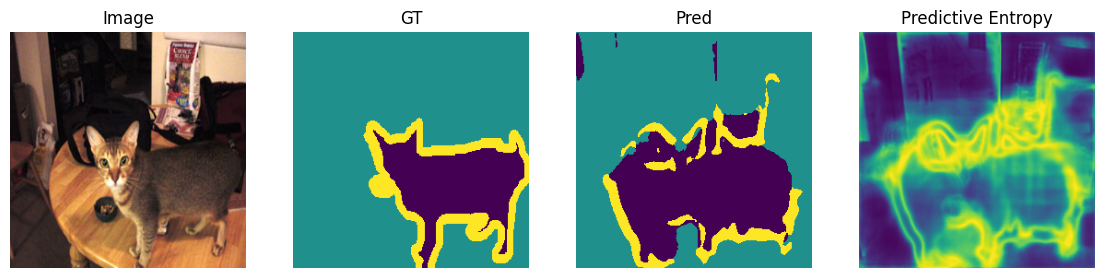

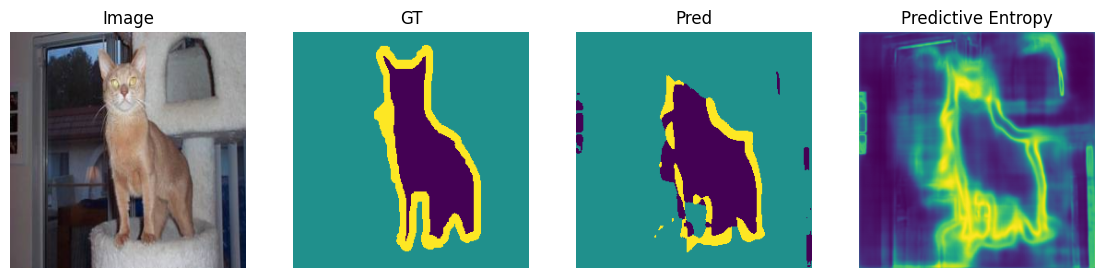

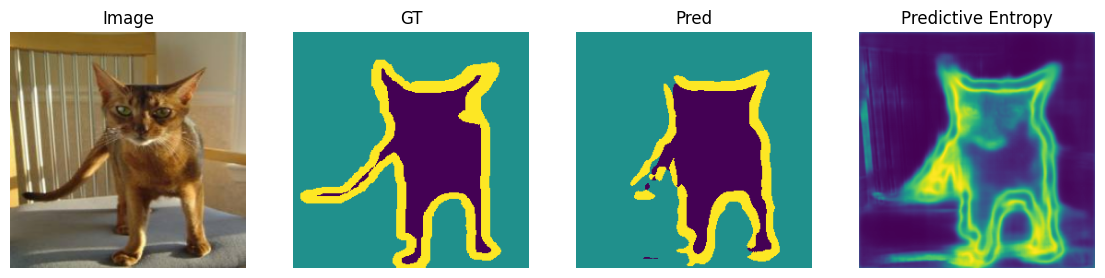


DONE


In [9]:
# Qualitative visualization

@torch.no_grad()
def show_batch_with_uncertainty(loader, n=3, T_mc=20, temp=1.0):
    x, y = next(iter(loader))
    x = x.to(device, non_blocking=True)
    y = y.to(device, non_blocking=True)

    _, pred, pe, mi, conf = mc_predict_streaming(model, x, T_mc=T_mc, temp=temp)

    # unnormalize for display
    mean = torch.tensor([0.485,0.456,0.406], device=device).view(1,3,1,1)
    std  = torch.tensor([0.229,0.224,0.225], device=device).view(1,3,1,1)
    img = (x * std + mean).clamp(0,1).detach().cpu()

    for i in range(min(n, x.size(0))):
        plt.figure(figsize=(14,4))
        plt.subplot(1,4,1); plt.imshow(img[i].permute(1,2,0)); plt.title("Image"); plt.axis("off")
        plt.subplot(1,4,2); plt.imshow(y[i].detach().cpu(), vmin=0, vmax=cfg.num_classes-1); plt.title("GT"); plt.axis("off")
        plt.subplot(1,4,3); plt.imshow(pred[i].detach().cpu(), vmin=0, vmax=cfg.num_classes-1); plt.title("Pred"); plt.axis("off")
        plt.subplot(1,4,4); plt.imshow(pe[i].detach().cpu()); plt.title("Predictive Entropy"); plt.axis("off")
        plt.show()

    del x, y, pred, pe, mi, conf, img
    cleanup_cuda()

show_batch_with_uncertainty(test_loader, n=3, T_mc=cfg.mc_samples, temp=T_star)

print("\nDONE")